# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In [1]:
from fastai.vision import *

### Download into file

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels.

In [3]:
data_place = {"telaviv": "sunset_telaviv.txt", "rio": "sunset_rio.txt", "london": "sunset_london.txt"}

You will need to run this line once per each category.

In [17]:
for folder, file in data_place.items():
    path = Path('data/sunset')
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(path/file, dest, max_pics=200)

In [20]:
classes = data_place.keys()

Then we can remove any images that can't be opened:

In [21]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

telaviv


cannot identify image file <_io.BufferedReader name='data/sunset/telaviv/00000022.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/telaviv/00000111.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/telaviv/00000032.jpg'>
rio


cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000143.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000040.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000080.png'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000116.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000089.png'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000025.png'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000074.png'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000059.jpg'>
london


Image data/sunset/london/00000050.png has 4 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/sunset/london/00000039.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/london/00000073.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/london/00000027.jpg'>


## View data

In [2]:
np.random.seed(42)
path = Path('data/sunset')
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [3]:
data.classes

['london', 'rio', 'telaviv']

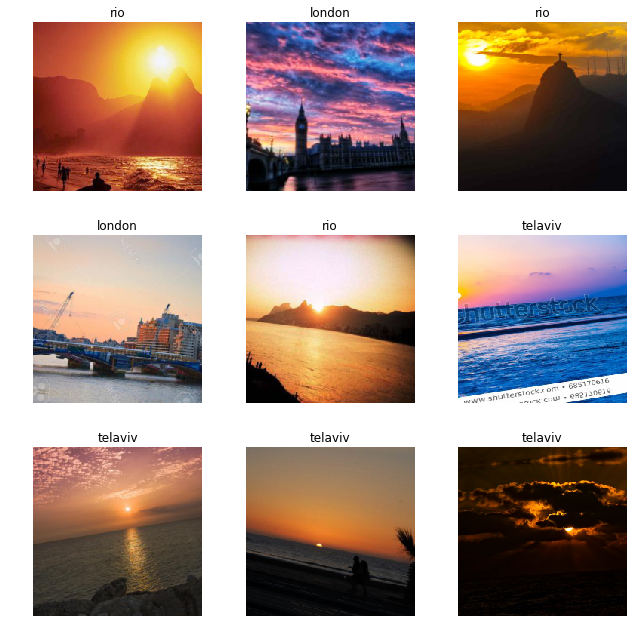

In [4]:
data.show_batch(rows=3, figsize=(9,9))

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['london', 'rio', 'telaviv'], 3, 381, 95)

## Train model

In [7]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [29]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.334201,0.829460,0.389474
2,1.041773,0.528862,0.200000
3,0.846677,0.492666,0.178947
4,0.725111,0.484423,0.168421


In [30]:
learn.save('stage-1')

In [58]:
learn.unfreeze()

In [59]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


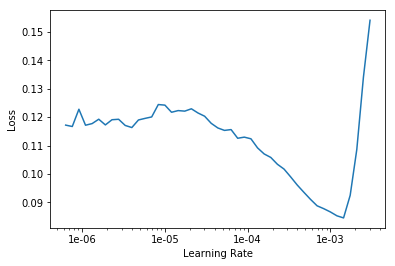

In [60]:
learn.recorder.plot()

In [73]:
learn.fit_one_cycle(5, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,error_rate
1,0.035263,0.198603,0.084211
2,0.033018,0.200118,0.084211
3,0.027070,0.196127,0.084211
4,0.024925,0.192470,0.084211
5,0.022292,0.195516,0.073684


In [76]:
learn.save('stage-3')

## Interpretation

In [8]:
learn.load('stage-3');

In [9]:
interp = ClassificationInterpretation.from_learner(learn)

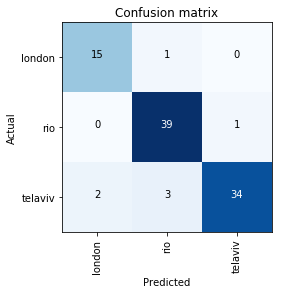

In [10]:
interp.plot_confusion_matrix()

## heatmap

In [10]:
from fastai.callbacks.hooks import *

In [11]:
m = learn.model.eval();

In [121]:
class HeatMap():
    def __init__(self, model, new_data, num = 9):
        self.model = model
        self.data = new_data
        self.num = num
        self.x,self.y, self.hook_a_proc, self.hook_g_proc = [[] for i in range(4)]
        self.export_images()
        
    def export_images(self):
        l = np.random.randint(95, size=(self.num))
        self.x = [self.data.valid_ds[idx][0] for idx in l]
        self.y = [self.data.valid_ds[idx][1] for idx in l]
        xb = [self.data.one_item(x)[0] for x in self.x]
        self.xb_im = [Image(self.data.denorm(x)[0]) for x in xb]
        self.xb = [x.cuda() for x in xb]
    
    def show_images(self, heat=False, grad=False):
        hm = self.hook_a_proc if not grad else self.hook_g_proc
        rows = int(np.ceil(math.sqrt(len(self.xb_im)))) if self.num !=3 else 3
        rows1 = row if self.num !=3 else 1
        axs = subplots(rows1, rows, imgsize=(224,224), figsize=(12,12))
        for i,x,y,ax in zip(range(len(self.xb_im)),self.xb_im, self.y, axs.flatten()):
            x.show(ax=ax, y=y)
            if heat:
                ax.imshow(hm[i], alpha=0.6, extent=(0,224,224,0),
                    interpolation='bilinear', cmap='magma');
            
    def hooked_backward(self, level=-1):
        self.hook_a, self.hook_g = [], []
        for i, x in enumerate(self.xb):
            with hook_output(self.model[0][level]) as hook_a:
                with hook_output(self.model[0][level], grad=True) as hook_grad:
                    preds = self.model(x)
                    preds[0, int(self.y[i])].backward()
            self.hook_a.append(hook_a); self.hook_g.append(hook_grad)
        self.process_grads()
        
    def process_grads(self):
        # regular
        self.hook_a_proc  = [hook.stored[0].cpu().mean(0) for hook in self.hook_a]
        # grad 
        grad = [hook.stored[0][0].cpu() for hook in self.hook_g]
        grad_chan = [g.mean(1).mean(1) for g in grad]
        self.hook_g_proc = [(g*g_chan[...,None,None]).mean(0) for g, g_chan in zip(grad,grad_chan)]

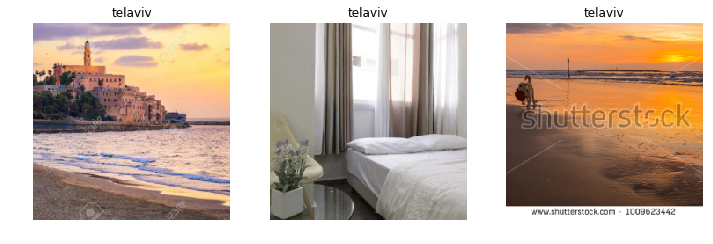

In [122]:
a = HeatMap(m,data, num=3)
a.show_images()

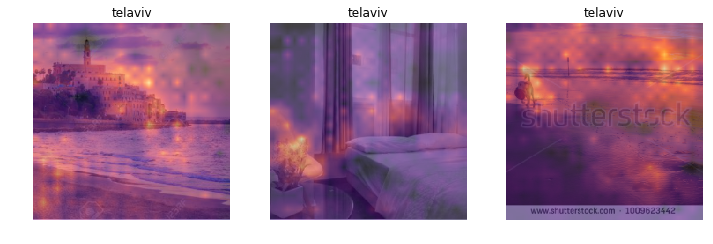

In [134]:
a.hooked_backward(level=5)
a.show_images(heat=True, grad=True)

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [138]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [140]:
defaults.device = torch.device('cpu')

In [150]:
!ls data/sunset/telaviv/

00000000.jpg  00000042.jpg   00000082.jpg  00000124.jpg  00000164.jpg
00000001.jpg  00000043.jpg   00000083.jpg  00000125.jpg  00000165.jpg
00000002.jpg  00000044.jpg   00000085.jpg  00000126.jpg  00000166.jpg
00000003.jpg  00000045.png   00000086.jpg  00000127.jpg  00000167.jpg
00000004.jpg  00000046.png   00000087.jpg  00000128.jpg  00000168.jpg
00000005.jpg  00000047.jpg   00000088.jpg  00000129.jpg  00000169.jpg
00000006.jpg  00000048.jpg   00000089.jpg  00000130.jpg  00000170.jpg
00000007.jpg  00000049.jpg   00000090.jpg  00000131.jpg  00000171.jpg
00000008.jpg  00000050.jpg   00000091.jpg  00000132.jpg  00000172.jpg
00000009.jpg  00000051.jpg   00000092.jpg  00000133.jpg  00000173.jpg
00000010.jpg  00000052.jpg   00000093.jpg  00000134.jpg  00000174.jpg
00000011.jpg  00000053.jpg   00000094.jpg  00000135.jpg  00000175.jpg
00000012.jpg  00000054.jpg   00000095.jpg  00000136.jpg  00000176.jpg
00000013.jpg  00000055.jpg   00000096.jpg  00000137.jpg  00000177.jpg
00000014.jpg  000000

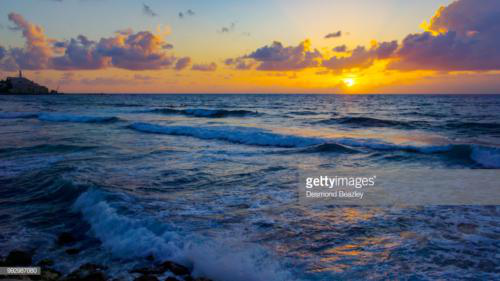

In [151]:
img = open_image(path/'telaviv/00000093.jpg')
img

We create our `Learner` in production enviromnent like this, jsut make sure that `path` contains the file 'export.pkl' from before.

In [152]:
learn = load_learner(path)

In [153]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category telaviv

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)